In [116]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

In [91]:
from FuncionesMineria import(analizar_variables_categoricas, cuentaDistintos, frec_variables_num, atipicosAmissing, patron_perdidos, ImputacionCuant, ImputacionCuali, Vcramer, hist_targetbinaria)

<h2> 2 - Preparacion de Datos </h2>

<h3>Extraccion de datos</h3>

In [92]:
datos = pd.read_excel("../Statement/DatosEleccionesEspaña.xlsx")

<h3>Asignar tipo de datos correctos</h3>

In [93]:
# Asignar tipo de datos correctos

colsFromFloatToInt = ["totalEmpresas", "Industria", "Construccion", "ComercTTEHosteleria", "Servicios", "inmuebles", "Pob2010", "PersonasInmueble"]
colsFromIntToBool = ["Izquierda", "Derecha", "AbstencionAlta"]

for c in colsFromFloatToInt:
    datos[c] = datos[c].fillna(-1)
    datos[c] = datos[c].astype(int)

for c in colsFromFloatToInt:
    datos[c] = datos[c].replace(-1, np.nan)

for c in colsFromIntToBool:
    datos[c] = datos[c].astype(bool)

<h3>3 - Analisis Descriptivo </h3>

In [94]:
print(analizar_variables_categoricas(datos))
print(cuentaDistintos(datos))
print(datos.describe().T)

{'Name':                    n         %
Name                          
Mieres             2  0.000246
Cieza              2  0.000246
Moya               2  0.000246
Rebollar           2  0.000246
Villaescusa        2  0.000246
...               ..       ...
Muras              1  0.000123
Monterroso         1  0.000123
Monforte de Lemos  1  0.000123
Mondoñedo          1  0.000123
Zuñeda             1  0.000123

[8100 rows x 2 columns], 'CCAA':                    n         %
CCAA                          
CastillaLeón    2248  0.276950
Cataluña         947  0.116669
CastillaMancha   919  0.113219
Andalucía        773  0.095232
Aragón           731  0.090058
ComValenciana    542  0.066773
Extremadura      387  0.047678
Galicia          314  0.038684
Navarra          272  0.033510
PaísVasco        251  0.030923
Madrid           179  0.022052
Rioja            174  0.021436
Cantabria        102  0.012566
Canarias          88  0.010841
Asturias          78  0.009609
Baleares          67  0.008

In [95]:
datos[datos.columns].isna().sum()

Name                              0
CodigoProvincia                   0
CCAA                              0
Population                        0
TotalCensus                       0
AbstentionPtge                    0
AbstencionAlta                    0
Izda_Pct                          0
Dcha_Pct                          0
Otros_Pct                         0
Izquierda                         0
Derecha                           0
Age_0-4_Ptge                      0
Age_under19_Ptge                  0
Age_19_65_pct                     0
Age_over65_pct                    0
WomanPopulationPtge               0
ForeignersPtge                    0
SameComAutonPtge                  0
SameComAutonDiffProvPtge          0
DifComAutonPtge                   0
UnemployLess25_Ptge               0
Unemploy25_40_Ptge                0
UnemployMore40_Ptge               0
AgricultureUnemploymentPtge       0
IndustryUnemploymentPtge          0
ConstructionUnemploymentPtge      0
ServicesUnemploymentPtge    

<h2>4 - Corrección de los errores detectados. </h2>
<h3>Tratamiento de datos incorrectos </h3>

In [96]:
categoricas = ["Densidad", "Population", "Name", "CCAA"]

for c in categoricas:
    datos[c] = datos[c].replace('nan',np.nan)

datos["Densidad"] = datos["Densidad"].replace('?', np.nan)

Vamos a tratar a las variables que representan porcentajes para poner como valor perdido cualquier observacion por fuera del rango de un porcentaje (0-100) la unica excepcion es la variable "PobChange_pct" ya que explicitamente esta explicado que los valores negativos aportan informacion

In [97]:
porcentajes = [
    "WomanPopulationPtge", "ForeignersPtge", "SameComAutonPtge", "SameComAutonDiffProvPtge", "DifComAutonPtge",
    "UnemployLess25_Ptge", "Unemploy25_40_Ptge", "UnemployMore40_Ptge", "AgricultureUnemploymentPtge", "IndustryUnemploymentPtge",
    "ConstructionUnemploymentPtge", "ServicesUnemploymentPtge", "AbstentionPtge", "Izda_Pct", "Dcha_Pct", "Otros_Pct", "Age_0-4_Ptge",
    "Age_under19_Ptge", "Age_19_65_pct", "Age_over65_pct"]

for c in porcentajes:
    datos[c] = [x if 0 <= x <= 100 else np.nan for x in datos[c]]

In [98]:

datos["ActividadPpal"] = datos["ActividadPpal"].replace(["Otro"], "Otros")


<h3>Eliminar variables objetivo y codificadora</h3>

<ul>
    <li>Izda Pct: Porcentaje de votos a partidos de izquierda (PSOE y Podemos) </li>
    <li>Izquierda: Variable dicotómica que toma el valor 1 si la suma de los votos de izquierdas es superior a la de derechas y otros y, 0, en otro caso. </li>
</ul>

In [99]:
varObjIzdaPct = datos["Izda_Pct"]
varObjIzquierda = datos["Izquierda"]

datos_input = datos.drop(["Izda_Pct", "Izquierda", "Name", "CodigoProvincia", "Dcha_Pct", "Otros_Pct", "AbstencionAlta", "Derecha"], axis=1)

<h3>5 - Analisis de valores atipicos y perdidos</h3>

In [100]:
numericas_input = datos_input.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns
categoricas_input = [variable for variable in list(datos_input.columns) if variable not in numericas_input]

calculamos porcentaje de atipicos de cada una de las variables continuas en el conjunto de datos.

In [101]:
pctAtipicosContinuas = {x: atipicosAmissing(datos_input[x])[1]/len(datos_input) for x in numericas_input}

<p>analizando el resultado observamos que las unicas que presentan valores atipicoss algo significativos es son la variable "Otros_Pct"(10.3%), la variable "Population"(9.9%) y "TotalCensus" (9.6%)</p>

<p>Vamos a proceder a pasar los valores atipicos a valores perdidos</p>

In [102]:
for x in numericas_input:
    datos_input[x] = atipicosAmissing(datos_input[x])[0]

Vamos a analizar la proporocion de datos perdidos en cada una de las variables de nuestro conjunto de datos

In [103]:
propMissingPorVariable = datos_input.isna().sum()/len(datos_input)


en este punto podemos observar gran parte de las que presentan un cierto porcentaje significativo de valores perdidos son las tres que ya habiamos observados que tenian valores atipicos y los habiamos transformado a valores perdidos.

Tambien podemos observar que se han sumado una mas "ForeignersPtge" con el 8%

vamos a analizar ahora la cantidad de valores perdidos para cada observacion, para hacer eso extraemos los estadisticos de la proporcion de datos perdidos para las obsevaciones 

In [104]:
datos_input['props_missings'] = datos_input.isna().mean(axis=1)
datos_input['props_missings'].describe()

count    8117.000000
mean        0.015441
std         0.027481
min         0.000000
25%         0.000000
50%         0.000000
75%         0.030303
max         0.333333
Name: props_missings, dtype: float64

de esta informacion concluimos que la media de datos perdidos por observacion es del 3% la observacion que mas variable perdidas tiene presenta el 28% de variables perdidas por lo que concluimos que no hace falta eliminar ninguna observacion ya que todas aportan una cantidad significativa de informacion

<h2>6 - Tratamiento de valores atipicos o perdidos </h2>

Las variables categoricas casi no presentan valores perdidos pero para evitar que los pocos que hayan provoquen distorision en la estimacion de la variable objetivo vamos a asignarle valores aleatorios.

En el caso de las variables numericas existen varias con algun porcentaje significativo de valores perdidos, para no perder la distribucion que originalmente presentan tambien vamos a otrgarle valores aleatorios. 

In [105]:
for x in numericas_input:
    datos_input[x] = ImputacionCuant(datos_input[x], 'aleatorio')

for x in categoricas_input:
    datos_input[x] = ImputacionCuali(datos_input[x], 'aleatorio')

datos_input.isna().sum()

CCAA                            0
Population                      0
TotalCensus                     0
AbstentionPtge                  0
Age_0-4_Ptge                    0
Age_under19_Ptge                0
Age_19_65_pct                   0
Age_over65_pct                  0
WomanPopulationPtge             0
ForeignersPtge                  0
SameComAutonPtge                0
SameComAutonDiffProvPtge        0
DifComAutonPtge                 0
UnemployLess25_Ptge             0
Unemploy25_40_Ptge              0
UnemployMore40_Ptge             0
AgricultureUnemploymentPtge     0
IndustryUnemploymentPtge        0
ConstructionUnemploymentPtge    0
ServicesUnemploymentPtge        0
totalEmpresas                   0
Industria                       0
Construccion                    0
ComercTTEHosteleria             0
Servicios                       0
ActividadPpal                   0
inmuebles                       0
Pob2010                         0
SUPERFICIE                      0
Densidad      

Al finalizar la depuracion guardamos los datos en nuevo fichero para tenerlo listo para trabajar sobre el conservando las fuentes de datos originales por si queremos volver para atras en alguna de las tareas que hicimos para depurar por algun error que hayamos cometido en el proceso

In [106]:
datosEleccionesEspañaDep = pd.concat([varObjIzquierda, varObjIzdaPct, datos_input], axis=1)
with open('datosEleccionesEspañaDep.pickle', 'wb') as archivo:
    pickle.dump(datosEleccionesEspañaDep, archivo)


<h2>7 - Analisis de relaciones entre variables<h2>

In [107]:
with open('datosEleccionesEspañaDep.pickle', 'rb') as f:
    datos_dep=pickle.load(f)

<h3>Variables objetivo con variables predictoras</h3>

Separamos las variables explicativas de las variables objetivo, excluimos las codificadoras

In [108]:
varObjIzdaPct = datos_dep['Izda_Pct']
varObjIzquierda = datos_dep['Izquierda']

datos_input = datos_dep.drop(['Izda_Pct', 'Izquierda', 'CCAA'], axis=1)

nombres_variables = list(datos_input.columns)

<h4>Izquierda</h4>

In [109]:

resultados_izquierda = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzquierda)
    resultados_izquierda.append((v,coeficiente_cramer))

resultados_izquierda.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_izquierda:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")


Izquierda

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.2696332168267661
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.20225769830015308
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.18549349056399067
ActividadPpal: Coeficiente V de Cramer = 0.1758742150757248
Explotaciones: Coeficiente V de Cramer = 0.161498532708309
SUPERFICIE: Coeficiente V de Cramer = 0.15993577596380187
inmuebles: Coeficiente V de Cramer = 0.14620869466361233
Age_over65_pct: Coeficiente V de Cramer = 0.14430329638784598
TotalCensus: Coeficiente V de Cramer = 0.1405199738127378
Age_under19_Ptge: Coeficiente V de Cramer = 0.1400798472767252
Pob2010: Coeficiente V de Cramer = 0.13562666094162304
Population: Coeficiente V de Cramer = 0.13543361573380172
Age_0-4_Ptge: Coeficiente V de Cramer = 0.13082036640640715
Unemploy25_40_Ptge: Coeficiente V de Cramer = 0.128175026286538
Age_19_65_pct: Coeficiente V de Cramer = 0.1224

El coefieciente V de Cramer va de 0 a 1 siendo 0 el valor que representa una relacion cercana a nula y 1 una relacion perfecta. Si bien tenemos gran cantidad de variables que aportan informacion explicativa ninguna parece esta fuertemente relacionada con la variable objetivo

<h5>Grafico de similitud de las distribuciones</h5>

<p>A continuacion graficamos una comparativa de las distribuciones de las variables mas y menos significativas (de menos a mas) para Izquierda</p>


<ul>
    <li>Menos significativas: Industria  y Servicios</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y AgricultureUnemploymentPtge</li>
</ul>

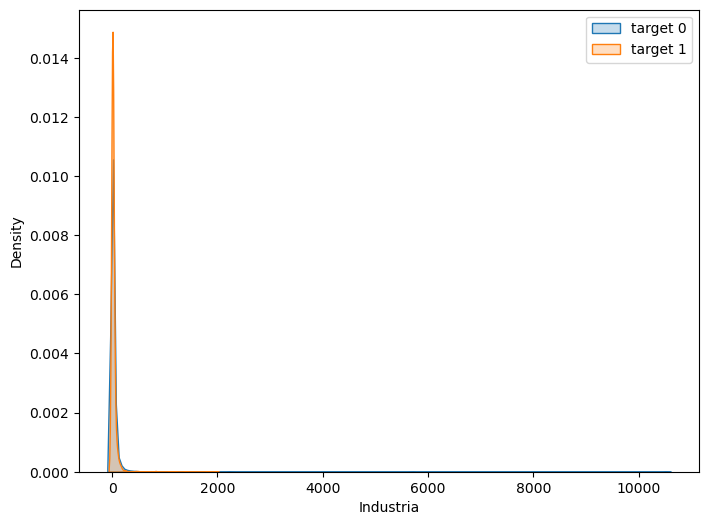

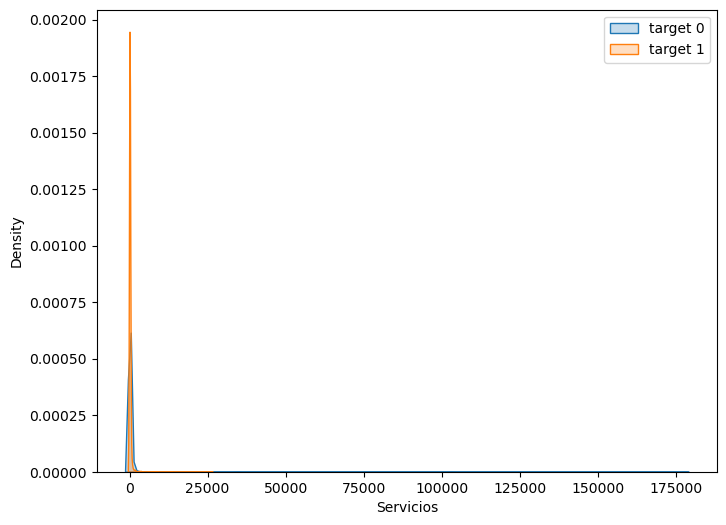

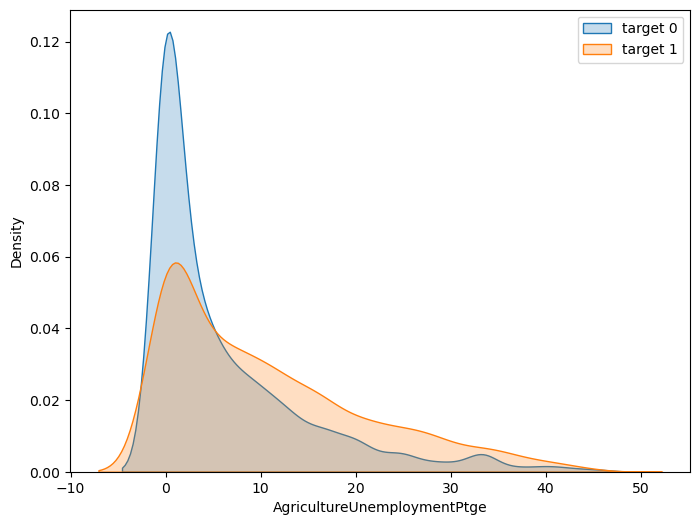

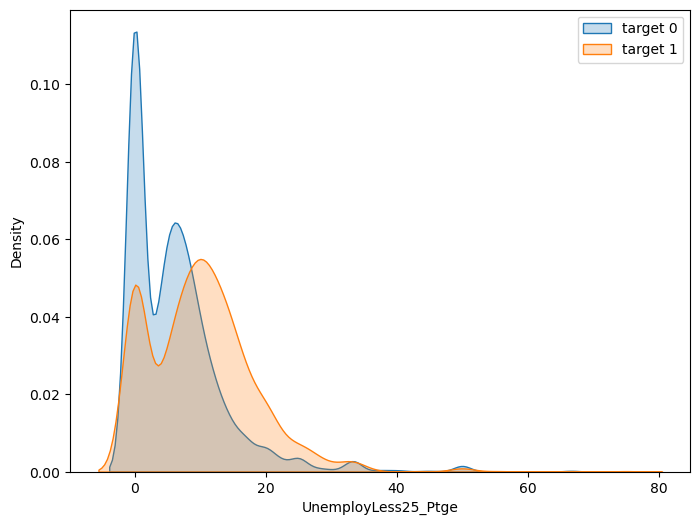

In [110]:
hist_targetbinaria(datos_input['Industria'],varObjIzquierda,'Industria')
hist_targetbinaria(datos_input['Servicios'],varObjIzquierda, 'Servicios')
hist_targetbinaria(datos_input['AgricultureUnemploymentPtge'],varObjIzquierda, 'AgricultureUnemploymentPtge')
hist_targetbinaria(datos_input['UnemployLess25_Ptge'],varObjIzquierda, 'UnemployLess25_Ptge')

<h4>Izda_Pct</h4>

In [111]:
resultados_Izda_Pct = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzdaPct)
    resultados_Izda_Pct.append((v,coeficiente_cramer))

resultados_Izda_Pct.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda_Pct")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_Izda_Pct:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")

Izquierda_Pct

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.20388428073198528
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.14606437384034196
AbstentionPtge: Coeficiente V de Cramer = 0.14078541697030386
SameComAutonDiffProvPtge: Coeficiente V de Cramer = 0.12704605191429247
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.12380657156559965
ActividadPpal: Coeficiente V de Cramer = 0.12001904706334858
SUPERFICIE: Coeficiente V de Cramer = 0.11747100845321384
IndustryUnemploymentPtge: Coeficiente V de Cramer = 0.11371385167379522
Age_0-4_Ptge: Coeficiente V de Cramer = 0.11072998895892325
Age_under19_Ptge: Coeficiente V de Cramer = 0.1100519036220996
Age_over65_pct: Coeficiente V de Cramer = 0.10853416378632302
inmuebles: Coeficiente V de Cramer = 0.10519535519421777
Explotaciones: Coeficiente V de Cramer = 0.10303564289317989
PersonasInmueble: Coeficiente V de Cramer = 0.10134820684356964
Pob2

<ul>
    <li>Menos significativas: Age_0-4_Ptge  y PersonasInmueble</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y SUPERFICIE</li>
</ul>

<h3>Relaciones entre variables predictoras continuas </h3>

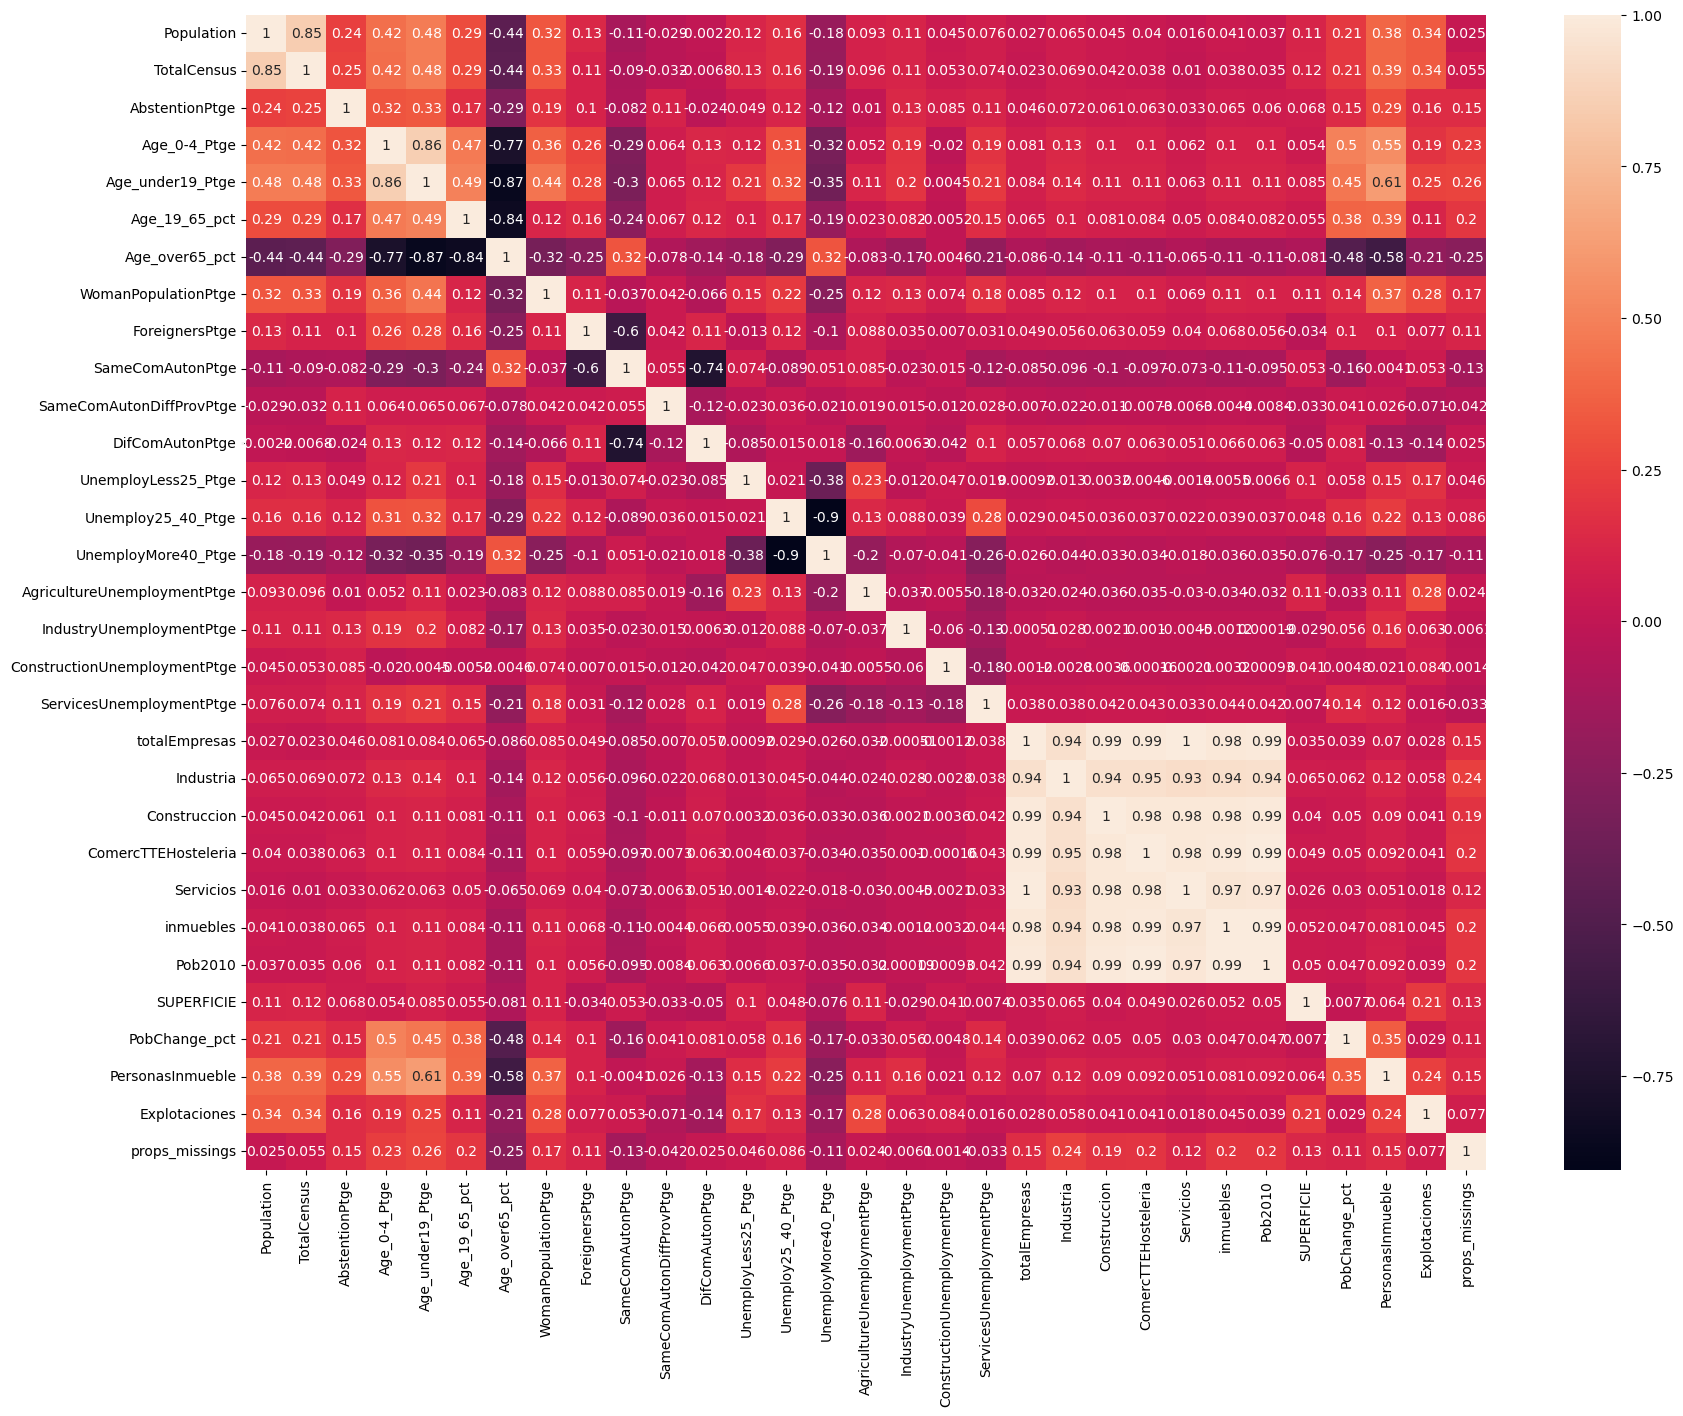

In [112]:
datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Como se puede observar existe una fuertisima correlacion en el siguiente grupo de variables: totalEmpresas, Industria, Construccion, ComercTTEHoteleria, Servicios, inmuebles y pob2010. Al estar tan correladas la informacion que aporten para explicar la variable objetivo probablemente sea redundante entre ellas.

Analizando un poco la relacion que existe entre estas variables y las dos variables objetivos nos damos cuenta que no tienen especial relacion, de hecho (en su mayoria) estan entre las que menos relacion tienen. Debido a esto decidi que voy a remover del conjunto de datos todas menos una de las variables, dejando solo la que mejor desempeño tiene en cuanto a la relacion que presenta con las variables objetivo: "inmuebles"

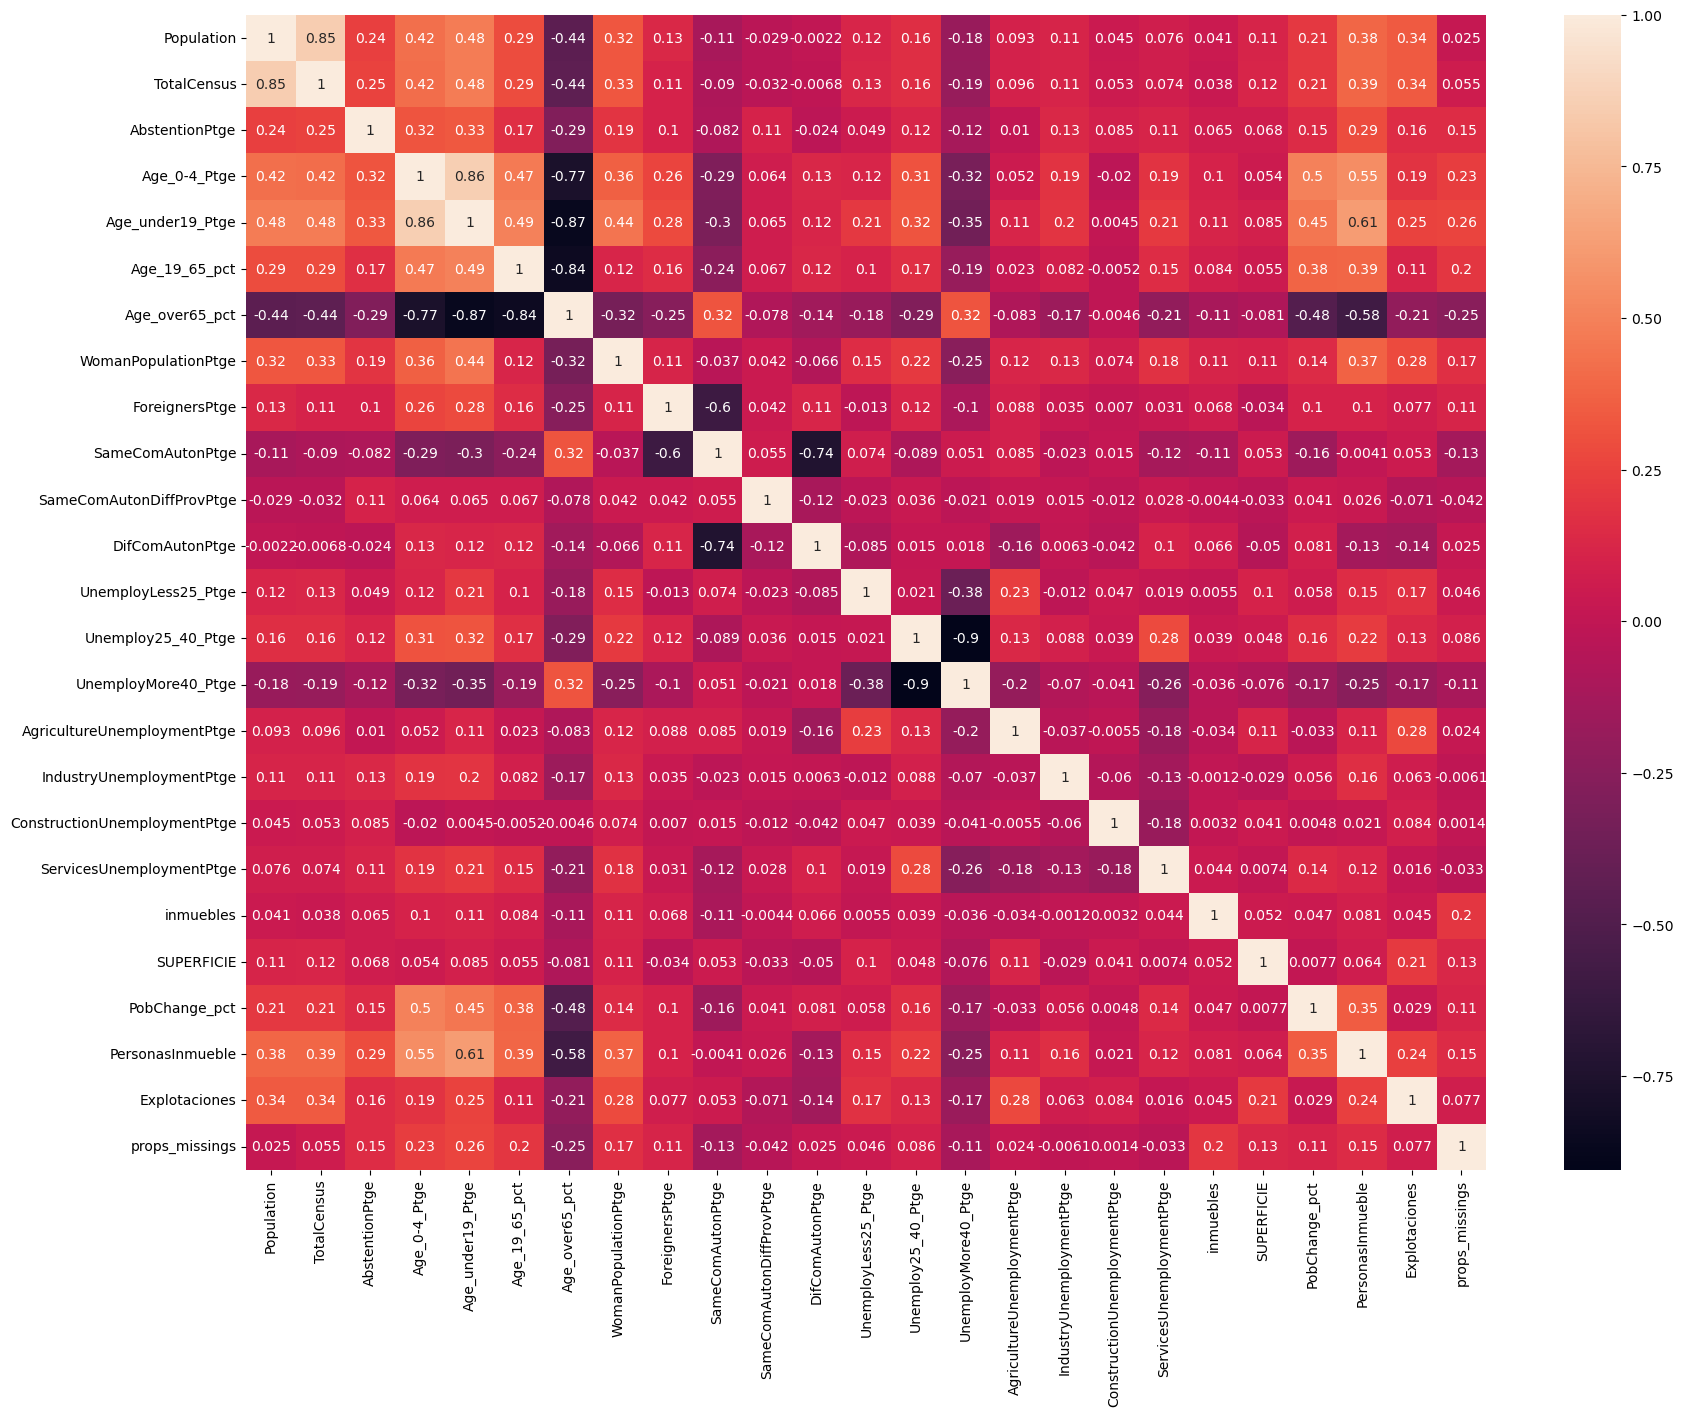

In [114]:
datos_input = datos_input.drop(['ComercTTEHosteleria', 'Industria', 'Servicios', 'Construccion', 'totalEmpresas', 'Pob2010'], axis=1)

datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

<h3>Muestras de entrenamiento y Test<h3>

Realizamos las particiones del conjunto de datos para entrenamiento del modelo y test, vamos a tener en cuenta todas las variables que han pasado por nuestra depuracion. Las particiones de datos para entrenamiento y prueba se hacen de manera independiente para cada variable objetivo.

In [119]:
izquierda_predictoras_train, izquierda_objetivo_train, izquierda_predictoras_test, izquierda_objetivo_test=train_test_split(
    datos_input, varObjIzquierda, test_size=0.2, random_state=123456)

izq_pct_predictoras_train, izq_pct_objetivo_train, izq_pct_predictoras_test, izq_pct_objetivo_test=train_test_split(
    datos_input, varObjIzdaPct, test_size=0.2, random_state=123456)

